In [72]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

import optax
from autograd import value_and_grad

In [73]:
# um to nm
nm = 1e-3

wavelength = 850 * nm
f0 = td.C_0 / wavelength
fwidth = f0 / 20

# NA selection
NA = 0.9

# Shape parameters of metalens unit cell (um)
H = 430 * nm
S = 320 * nm

# 최소, 최대 실린더의 반경
rmin = 50 * nm
rmax = S / 2 - 10 * nm

buffer_z = wavelength / 2
buffer_xy = wavelength

# Metalens diameter
diameter = 10

n_Si = 3.84  # aSi
n_SiO2 = 1.45
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
Si = td.Medium(permittivity=n_Si**2)

# define symmetry
symmetry = (-1, 1, 0)

# simulation run time
run_time = 100 / fwidth
min_steps_per_wvl = 10

In [74]:
length_xy = diameter + 2 * buffer_xy 
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

length_z = H + 2 * buffer_z
sim_size = (length_xy, length_xy, length_z)

In [75]:
def get_cylinder_centers(diameter, spacing, full_circle: bool = False):
    r_eff = diameter / 2 - spacing / 2  # max radius of centers
    coords = np.arange(0, r_eff, spacing)

    if full_circle:
        coords = np.concatenate([-coords[::-1], coords])

    x, y = np.meshgrid(coords, coords)
    points = np.vstack((x.flat, y.flat)).T

    # Create a boolean mask for points within the circle
    mask = x**2 + y**2 <= r_eff**2

    # Apply the mask to get the final points
    return points[mask.flat]

centers_quarter = get_cylinder_centers(diameter, S, full_circle=False)
centers_full = get_cylinder_centers(diameter, S, full_circle=True)
N = len(centers_full)

print(f"For a diameter of {diameter:.1f} µm, there are {N} cylinders.")
print(
    f"The metalens has an area of {np.pi * (diameter/2)**2:.1f} µm² and a focal length of {focal_length:.1f} µm."
)

For a diameter of 10.0 µm, there are 780 cylinders.
The metalens has an area of 78.5 µm² and a focal length of 2.8 µm.


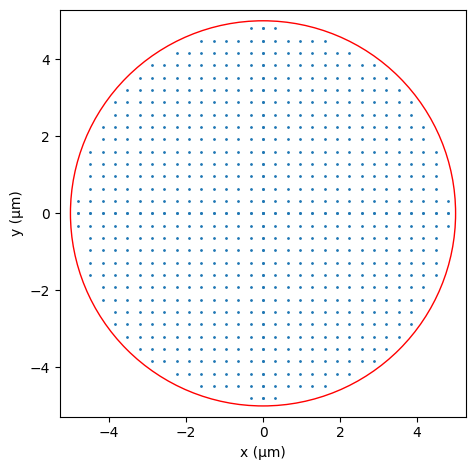

In [76]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.scatter(*get_cylinder_centers(diameter, S, full_circle=True).T, s=1)
circle = plt.Circle((0, 0), diameter / 2, color="r", fill=False)
ax.add_artist(circle)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_aspect("equal")
plt.show()

In [77]:
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-td.inf, -td.inf, -1000),
        rmax=(+td.inf, +td.inf, -H / 2),
    ),
    medium=SiO2,
)

aperture = [
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-td.inf, -td.inf, -H / 2),
            rmax=(+td.inf, +td.inf, -H / 2 + 0.2),
        ),
        medium=td.PECMedium(),
    ),
    td.Structure(
        geometry=td.Cylinder(
            center=(0, 0, 0),
            radius=diameter / 2 + buffer_xy / 4,
            length=H,
        ),
        medium=air,
    ),
]

def make_cylinders(params):
    """Make the metalens unit cell structures."""
    # scale the parameters to be between rmin and rmax
    radii = rmin + (rmax - rmin) / (1 + np.exp(-params))

    geometries = []
    for r, (x, y) in zip(radii, centers_quarter):
        geometry = td.Cylinder(center=(x, y, 0), radius=r, length=H)
        geometries.append(geometry)
    geo_group = td.GeometryGroup(geometries=geometries)
    medium = td.Medium(permittivity=n_Si**2)

    return td.Structure(medium=medium, geometry=geo_group)

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0, 0, -H / 2 - buffer_z / 2),
    direction="+",
    pol_angle=0,
)

In [78]:
# make monitor
monitor_near = td.FieldMonitor(
    center=(0, 0, H / 2 + buffer_z / 2),
    size=(td.inf, td.inf, 0),
    freqs=[f0],
    name="near_fields",
    colocate=False,
)

monitor_far = td.FieldProjectionAngleMonitor(
    center=monitor_near.center,
    size=monitor_near.size,
    freqs=monitor_near.freqs,
    name="far_fields",
    phi=[0],
    theta=[0],
    proj_distance=focal_length - buffer_z / 2,
    far_field_approx=False,
)

In [79]:
def make_sim(params):
    structures = [substrate, *aperture]
    if params is not None:
        structures.append(make_cylinders(params))
    sim = td.Simulation(
        size=sim_size,
        structures=structures,
        sources=[source],
        monitors=[monitor_near],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(td.PML()),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        symmetry=symmetry,
    )
    return sim

params0 = np.zeros(len(centers_quarter))
sim = make_sim(params0)

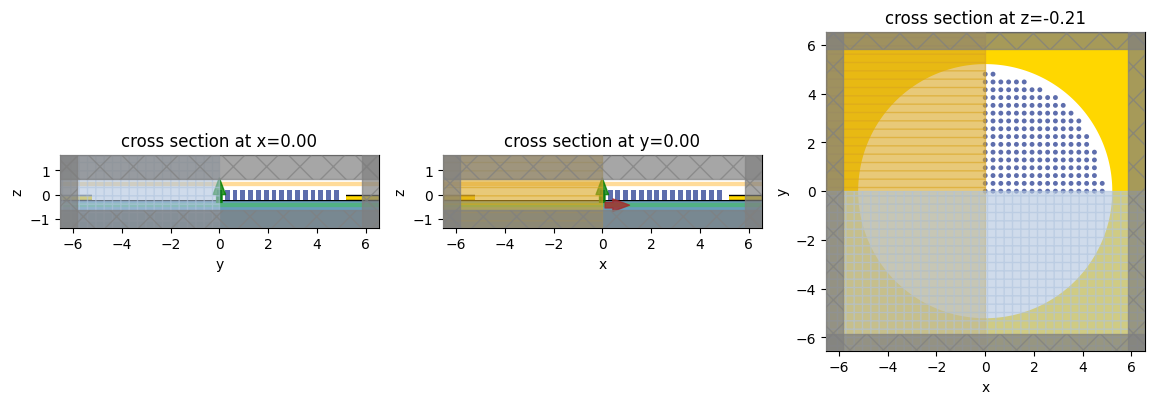

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=-H / 2, ax=ax3)  # so we can see the aperture
plt.show()

In [81]:
def measure_focal_power(sim_data: td.SimulationData) -> float:
    """Measures far field power at focal point."""
    projector = td.FieldProjector.from_near_field_monitors(
        sim_data=sim_data,
        near_monitors=[monitor_near],
        normal_dirs=["+"],
        pts_per_wavelength=None,
    )
    projected_fields = projector.project_fields(monitor_far)
    return projected_fields.power.sum().item()


def J(params) -> float:
    """Objective function, returns power at focal point as a function of params."""
    sim = make_sim(params)
    sim_data = web.run(sim, task_name="metalens_invdes", verbose=False)
    return measure_focal_power(sim_data)

In [82]:
dJ = value_and_grad(J)

val, grad = dJ(params0)
print(val)
print(grad)

J_empty = J(None)


def J_normalized(params):
    return J(params) / J_empty


val_normalized = val / J_empty

dJ_normalized = value_and_grad(J_normalized)

print(val_normalized)

c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

0.004179057587730168
[ 3.80610769e-04  3.58285155e-04  2.22833226e-04  6.84433994e-05
 -8.14865351e-05 -1.03359431e-04 -2.40873467e-05  2.91074162e-05
  3.97315440e-05 -3.03727773e-07 -3.24280943e-05 -6.53450325e-06
  3.39525581e-05 -3.09965271e-05  6.57944926e-06  5.65948852e-05
  3.89981387e-04  3.60664185e-04  2.20255574e-04  4.72475029e-05
 -1.05916593e-04 -9.96788088e-05 -1.00352252e-05  3.14395062e-05
  3.15458823e-05 -6.37833013e-06 -2.67717322e-05 -1.27468337e-08
  3.48510335e-05 -3.77409304e-05  1.08608802e-05  4.47856444e-05
  3.54266507e-04  3.29772129e-04  1.56018946e-04 -3.73632212e-05
 -1.38264388e-04 -9.43263465e-05  4.21198067e-06  4.00646512e-05
  2.81943219e-05 -1.44890157e-05 -2.84279982e-05  3.92161991e-06
  3.44920996e-05 -4.37802059e-05  1.26493006e-05  2.25288964e-04
  1.81114739e-04 -5.86083431e-06 -1.43746641e-04 -1.62498172e-04
 -5.58480427e-05  4.14428045e-05  4.88473161e-05  1.07752852e-05
 -2.50894219e-05 -1.68531217e-05  1.29898953e-05  1.54959178e-05
 -3.

c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

0.2976430827163431


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 1
	J = 2.9764e-01
	grad_norm = 1.0639e-01


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 2
	J = 2.3227e+00
	grad_norm = 2.7799e-01


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 3
	J = 5.1106e+00
	grad_norm = 5.0753e-01


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 4
	J = 8.4927e+00
	grad_norm = 4.3168e-01


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 5
	J = 1.2929e+01
	grad_norm = 6.1238e-01


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 6
	J = 1.9196e+01
	grad_norm = 1.0103e+00


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 7
	J = 2.6001e+01
	grad_norm = 1.2616e+00


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 8
	J = 3.0027e+01
	grad_norm = 1.1806e+00


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 9
	J = 3.3209e+01
	grad_norm = 1.2961e+00


c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

step = 10
	J = 3.4991e+01
	grad_norm = 1.6491e+00


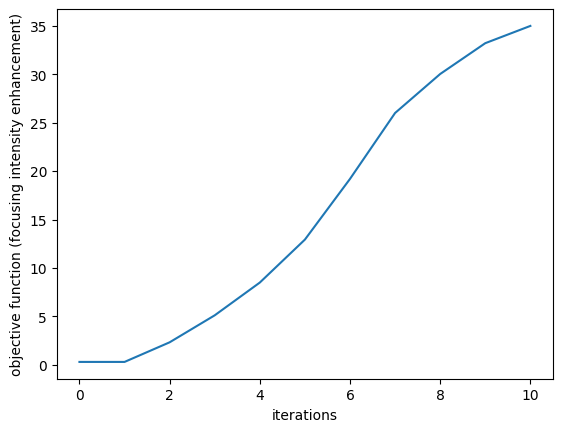

In [83]:
# Optimization

# hyperparameters
num_steps = 10
learning_rate = 1e-1

# initialize adam optimizer with starting parameters
params = np.copy(params0)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
J_history = [val_normalized]
params_history = [params0]

for i in range(num_steps):
    # compute gradient and current objective function value
    value, gradient = dJ_normalized(params)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    # save history
    J_history.append(value)
    params_history.append(params)

params_after = params_history[-1]

plt.plot(J_history)
plt.xlabel("iterations")
plt.ylabel("objective function (focusing intensity enhancement)")
plt.show()

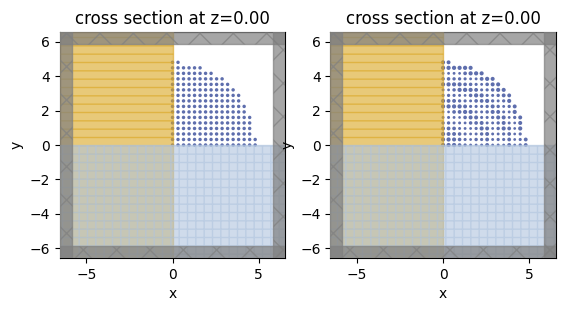

In [84]:
sim_before = make_sim(params0)
sim_after = make_sim(params_after)

f, (ax1, ax2) = plt.subplots(1, 2)

sim_before.plot(z=0, ax=ax1)
sim_after.plot(z=0, ax=ax2)

plt.show()

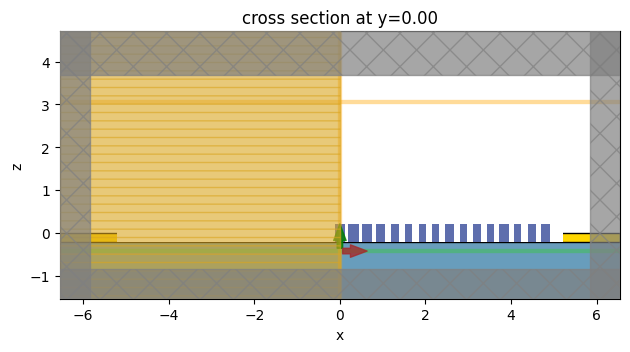

In [85]:
sim_after_mnt_xy = td.FieldMonitor(
    center=(*monitor_near.center[:2], H / 2 + focal_length),
    size=monitor_near.size,
    freqs=monitor_near.freqs,
    fields=("Ex", "Ey", "Ez"),
    name="focal_fields_xy",
)
sim_after_mnt_xz = td.FieldMonitor(
    size=(0, td.inf, td.inf),
    freqs=monitor_near.freqs,
    fields=("Ex", "Ey", "Ez"),
    name="focal_fields_yz",
)
sim_after_mnt = sim_after.updated_copy(
    center=(0, 0, focal_length / 2),
    size=(length_xy, length_xy, focal_length + 4 * buffer_z),
    monitors=[sim_after_mnt_xy, sim_after_mnt_xz],
)
sim_after_mnt.plot(y=0)
plt.show()

18:18:35 대한민국 표준시 Created task 'meta_near_field_after' with task_id      
                         'fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700' and        
                         task_type 'FDTD'.

                  View task using web UI at                                     
                  ]8;id=257068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=299312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\taskId]8;;\]8;id=257068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\=]8;;\]8;id=795703;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\fdve]8;;\]8;id=257068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\-9faf53f]8;;\
                  ]8;id=257068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\3-afda-48ec-aed3-2c5c6b318700']8;;\.

c:\Users\Min\anaconda3\envs\M2ni\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

18:18:37 대한민국 표준시 status = queued

                  To cancel the simulation, use 'web.abort(task_id)' or         
                  'web.delete(task_id)' or abort/delete the task in the web UI. 
                  Terminating the Python script will not stop the job running on
                  the cloud.

18:18:42 대한민국 표준시 status = preprocess

18:18:43 대한민국 표준시 Maximum FlexCredit cost: 0.419. Use                    
                         'web.real_cost(task_id)' to get the billed FlexCredit  
                         cost after a simulation run.

                  starting up solver

18:18:44 대한민국 표준시 running solver

18:18:58 대한민국 표준시 early shutoff detected at 12%, exiting.

                  status = postprocess

18:18:59 대한민국 표준시 status = success

18:19:00 대한민국 표준시 View simulation result at                              
                         ]8;id=718979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=716464;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\taskId]8;;\]8;id=718979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\=]8;;\]8;id=761712;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\fdve]8;;\]8;id=718979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\-]8;;\
                         ]8;id=718979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9faf53f3-afda-48ec-aed3-2c5c6b318700\9faf53f3-afda-48ec-aed3-2c5c6b318700']8;;\.

18:19:04 대한민국 표준시 loading simulation from simulation_data.hdf5

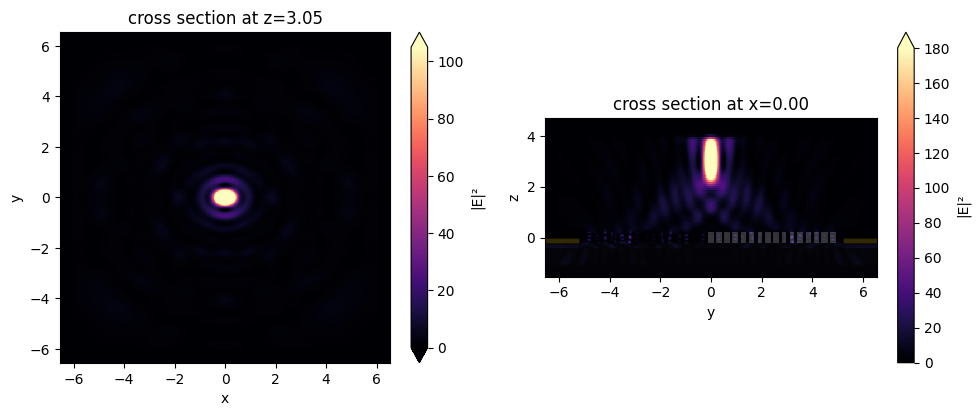

In [88]:
sim_data_after_mnt = web.run(sim_after_mnt, task_name="meta_near_field_after")


fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data_after_mnt.plot_field("focal_fields_xy", field_name="E", val="abs^2", vmax=105, ax=ax1)
sim_data_after_mnt.plot_field("focal_fields_yz", field_name="E", val="abs^2", vmax=180, ax=ax2)
plt.show()